# SOFIA/FORCAST Galactic Center Source Detection Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [276]:
#Load in the configuration file 
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field01', 'Field02', 'Field03', 'Field04', 'Field05', 'Field06', 'Field07', 'Field08', 'Field09', 'Field10', 'Field11', 'Field12', 'Field13', 'Field14', 'Field15', 'Field16', 'Field17', 'Field18', 'Field19', 'Field20', 'Field21', 'Field22', 'Field23', 'Field24', 'Field25', 'Field26', 'Field27', 'Field28', 'Field29', 'Field30', 'Field31', 'Field32', 'Field33', 'Field34', 'Field35', 'Field36', 'Field37', 'Field38', 'Field39', 'Field40', 'Field41', 'Field42', 'Field43', 'Field44', 'Field45', 'Field46', 'Field47', 'Field48', 'Field49', 'Field50', 'Field51', 'Field52']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [277]:
#import configuration for selected file - Chage 'Field52' to the desired field name from the list above
from config import Field52 as field
from config import dpath, dpathalt, ds9path

In [278]:
wvlist=[]
for info in wv._registry:
    wvlist.append(info.name)
print('\nNames of available configurations for wavelength filters:, ', wvlist)


Names of available configurations for wavelength filters:,  ['F252', 'F371']


In [279]:
from config import F252 as filt

#rename a few parameters that were just imported. 
bkgbox=filt.bkgbox
finddetsig=filt.finddetsig
segdetsig=filt.segdetsig
wavelength=filt.wavelength

In [280]:
#import all required packages
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord,Angle 
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy import units as u
from astropy.stats import SigmaClip,sigma_clipped_stats
from astropy.table import join, Table, vstack

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, CircularAperture
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils import DAOStarFinder,IRAFStarFinder, make_source_mask
#from photutils.utils import calc_total_error

from regions import read_ds9, write_ds9, CircleSkyRegion

from FORCASTphot import addSkyCentroid, makeDS9reg, CombDS9files, findNOTindex

## First Steps - Load data & perform background subtraction

In [281]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)
    
if wavelength==25:
    fname=field.file25
elif wavelength==37:
    fname=field.file37
else:
    print("Error. Wavelength should be either 25 or 37.")

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

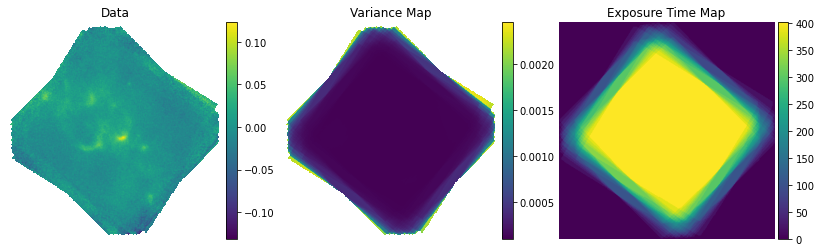

In [282]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))

ax1.set_title('Data')
im1=ax1.imshow(data,origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_axis_off()

ax2.set_title('Variance Map')
im2=ax2.imshow(varmap,origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_axis_off()

ax3.set_title('Exposure Time Map')
im3=ax3.imshow(tmap,origin='lower')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
ax3.set_axis_off()
plt.show()

## Updated Background Estimation Method

In [283]:
#create initial background model for building source mask
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MMMBackground(sigma_clip=sigma_clip)  #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(7,7),bkg_estimator=bkg_estimator,edge_method='pad')
bkg=bkg_data.background


In [284]:
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

#create masked array for the background subtracted data
data_ma = np.ma.masked_array(data, mask=maskTPS)

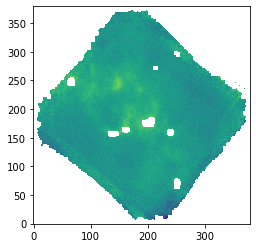

In [285]:
mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3,
                               dilate_size=4, filter_fwhm=3)

data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)

plt.imshow(data_ma2,origin='lower')
plt.show()

In [286]:
#create updated background model detected sources masked
bkg_data = Background2D(data_ma2,(7,7),bkg_estimator=bkg_estimator,edge_method='pad')
bkg_rms=bkg_data.background_rms 
bkg=bkg_data.background

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms - Note this is a 2D array
threshold = segdetsig*bkg_rms

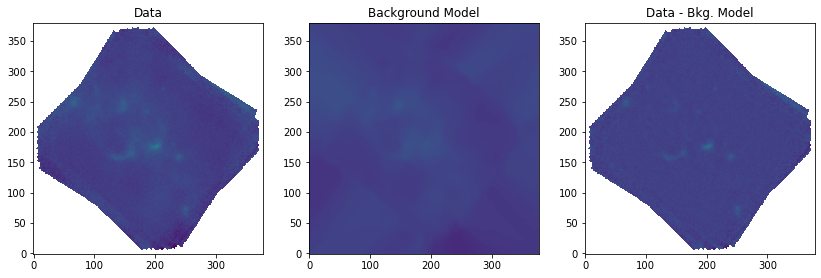

In [287]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.42

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

## Source Detection using DAO and IRAF routines

In [288]:
#First, create a mask for the data
#Make a cut based on exposure time. Note this is more agressive than SEG because we can't use 2D background with DAO or IRAF
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
maskTPS=np.where(tmapnorm<0.75,tmapnorm,0).astype('bool')

mask2=np.zeros(np.shape(maskTPS))
mask3=np.zeros(np.shape(maskTPS))

#create a single mask from the combination of mask parameters specified in the config file
#if field.m3lims is not None:
#    maskPS=(maskTPS == 1) | (mask2 == 1) | (mask3 == 1)
#elif field.m3lims is not None:
#    maskPS=(maskTPS == 1) | (mask2 == 1)
#else:
#    maskPS=(maskTPS == 1)

#create a single mask from the combination of mask parameters specified in the config file
if field.m2lims is not None:
    maskPS=(maskTPS == 1) | (mask2 == 1)
else:
    maskPS=(maskTPS == 1)


#create masked array for the background subtracted data
data_bkgsub_ma = np.ma.masked_array(data_bkgsub, mask=maskPS)

#plot the masked data - optional
#plt.figure()
#plt.imshow(data_bkgsub_ma,origin='lower')
#plt.colorbar()
#plt.show()

In [289]:
#get standard devaition of image to specify detection threshold
#std = np.median(bkg_rms) # use rms map value from background model - must be single value becuase methods don't allow for passing an array

#Alternatively - use sigma_clipped_stats on the image to estimate background for source finding
mean, median, std = sigma_clipped_stats(data_bkgsub_ma, sigma=3.0)  

In [290]:
#now run starfinder routines to find sources 
daofind = DAOStarFinder(fwhm=5, threshold=finddetsig*std)
DAOsources = daofind(data_bkgsub_ma,mask=maskPS)

#StarFinder = IRAFStarFinder(fwhm=5, threshold=finddetsig*std)
#IRAFsources = StarFinder(data_bkgsub_ma,mask=maskPS)

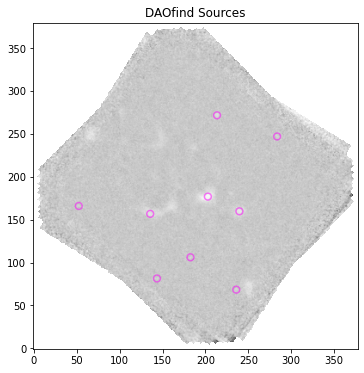

In [291]:
#plot data with apertures on detected sources
if DAOsources is not None:
    Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
    Dapertures = CircularAperture(Dpositions, r=4.)

#if IRAFsources is not None:
#    Ipositions = np.transpose((IRAFsources['xcentroid'], IRAFsources['ycentroid']))
#    Iapertures = CircularAperture(Ipositions, r=4.)
    

norm = ImageNormalize(stretch=SqrtStretch())

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
fig, ax1 = plt.subplots(1,1,figsize=(8,6))

ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r',norm=norm)
ax1.set_title('DAOfind Sources')
if DAOsources is not None:
    Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax1)
    
#ax2.imshow(data_bkgsub, origin='lower', cmap='Greys_r',norm=norm)
#ax2.set_title('IRAF StarFind Sources')
#if IRAFsources is not None:
#    Iapertures.plot(color='cyan', lw=1.5, alpha=0.5,axes=ax2)

plt.show()

In [292]:
#add skycoords to source tables
if DAOsources is not None:
    DAOsources=addSkyCentroid(DAOsources,wcsmap)

#if IRAFsources is not None:
#    IRAFsources=addSkyCentroid(IRAFsources,wcsmap)

## Source Detection using Segmentation Map - does better in dithered regions

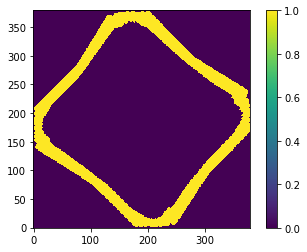

In [293]:
#create mask for 'bad' parts of the image (e.g., edges of field where dithers don't overlap well)
mask=np.where(tmapnorm<0.32,tmapnorm,0).astype('bool') #create mask for any locations less than specified fraction of total integration time
#note this can be adjusted in the config file parameters #

#plot any of the mask to verify
plt.figure()
plt.imshow(mask,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [294]:
#Use a gaussian to smooth image prior to running the segmentation map - (FWHM 3x3, but can be adjusted in the line below)
sigma = 3.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

In [295]:
#Create Segmentation Map and detect sources
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=10, kernel=kernel)

In [296]:
#remove any that exist in masked region as defined in the config file
if field.m2lims is not None:
    mask2=np.zeros(np.shape(mask))
    for lim in field.m2lims:
        mask2[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask2.astype('bool'))
#if field.m3lims is not None:
#    mask3=np.zeros(np.shape(mask))
#    for lim in field.m3lims:
#        mask3[lim[0]:lim[1],lim[2]:lim[3]]=1
#    segm.remove_masked_labels(mask3.astype('bool'))

In [297]:
#Perform deblending on sources found in segmentation map
if segm is not None:
    segm_deblend = deblend_sources(data_bkgsub, segm, npixels=11,kernel=kernel, nlevels=64,contrast=0.001)
else:
    segm_deblend=segm #if segm is empty pass it on to avoid errors

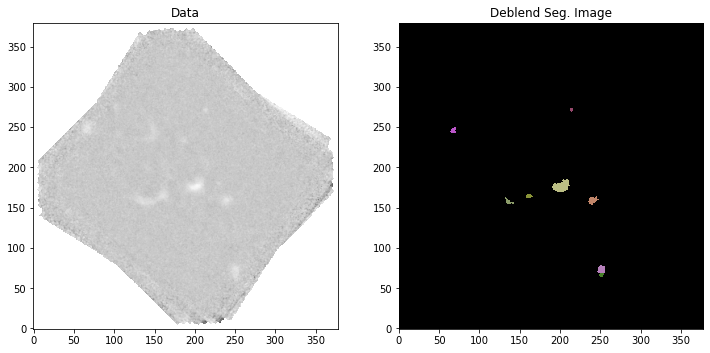

In [298]:
#make plot of segmentation image to show detected sources side by side with data
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
if segm is not None:
    cmap = segm_deblend.make_cmap(seed=123)
    ax2.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Deblend Seg. Image')
plt.show()

In [299]:
#Build a table from the deblended segmentation map
if segm is not None:
    cat = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
    #columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background', 'area',
    #     'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
    #     'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#Specify table columns
    columns=['label','xcentroid','ycentroid','sky_centroid']
    SEGsources= cat.to_table(columns)
else:
    SEGsources=segm #if segm is empty pass it on to avoid errors


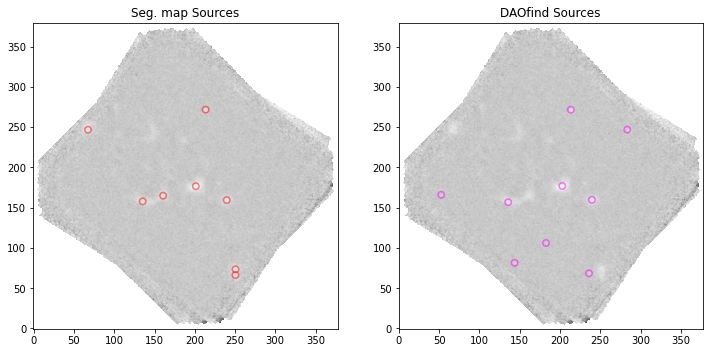

In [300]:
#plot data with apertures on detected sources
if DAOsources is not None:
    Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
    Dapertures = CircularAperture(Dpositions, r=4.)
    
if SEGsources is not None:
    Spositions = np.transpose((SEGsources['xcentroid'], SEGsources['ycentroid']))
    Sapertures = CircularAperture(Spositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())
#norm = ImageNormalize(stretch=SqrtStretch(),vmin=0.02,vmax=1.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Seg. map Sources')
if SEGsources is not None:
    Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax1)

ax2.imshow(data_bkgsub, origin='lower', cmap='Greys_r',norm=norm)
ax2.set_title('DAOfind Sources')
if DAOsources is not None:
    Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax2)


plt.show()

## Create ds9 region files to examine sources from above steps

In [301]:
#specify size of regions
radius = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"

#name to save file under and call to function creating the ds9 region file - Segmentation Map Sources
savenameSEG= field.name+'_segFind.reg'
t1=makeDS9reg(savenameSEG,SEGsources,radius,color='red')

#name to save file under and call to function creating the ds9 region file - DAOfind Sources
savenameDAO= field.name+'_daoFind.reg'
t2=makeDS9reg(savenameDAO,DAOsources,radius,color='magenta')

#save both sets of regions under the same file
savename=field.name+'.reg'
CombDS9files(t1,t2,savename)

In [302]:
#open ds9 and load in the region file to show sources - Note ds9 path must be correctly defined in config file for this to work
if ds9path is not None:
    subprocess.Popen(ds9path+' '+fname+ ' -mode region -regions load '+field.name+'.reg',shell=True) 

## Optional -  add user defined sources

User defined sources can be added to run with the photometry code. Simply create a new ds9 region file with the source positions added as regions. Name the file with the user defined sources field.name+'_ds9.reg' and specify the coordinates as Fk5 when saving. This will be loaded in the cells below and then passed to the photometry script if present. If the file does not exist, these steps will be skipped.

In [305]:
#read in user defined sources if they exist
UserFile=field.name+'_ds9.reg'
if os.path.isfile(field.name+'_ds9.reg'):
    sourcesDS9=read_ds9(field.name+'_ds9.reg')

    clist=[]
    
    for source in sourcesDS9:
        if source.visual['color']=='green':
            sc=source.center
            ra=sc.ra.value
            dec=sc.dec.value
            a=(ra,dec)
            clist.append(a)
            
    ds9sc=SkyCoord(clist,unit=u.deg,frame='fk5')
    usersources=True
    print('Number of user defined DS9 sources found: ', len(clist))  
else:
    usersources=False
    print('No user defined DS9 sources found')

No user defined DS9 sources found


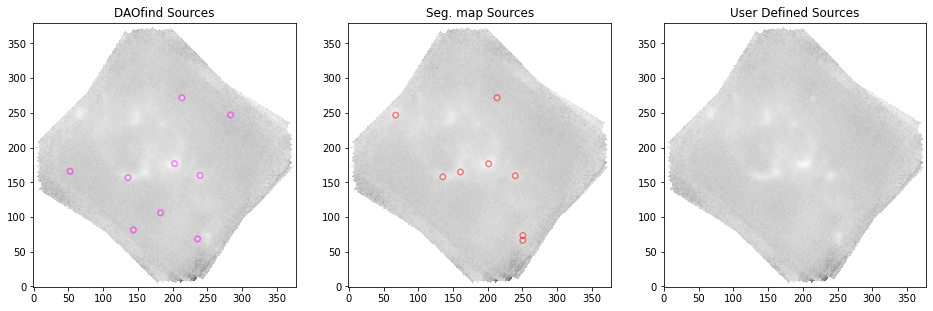

In [306]:
#plot data with sources found in each method used
if DAOsources is not None:
    Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
    Dapertures = CircularAperture(Dpositions, r=4.)
    
if SEGsources is not None:
    Spositions = np.transpose((SEGsources['xcentroid'], SEGsources['ycentroid']))
    Sapertures = CircularAperture(Spositions, r=4.)
    
if usersources:
    Upositions=np.transpose(skycoord_to_pixel(ds9sc,wcsmap))
    Uapertures = CircularAperture(Upositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

ax1.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax1.set_title('DAOfind Sources')
if DAOsources is not None:
    Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax1)
    
ax2.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax2.set_title('Seg. map Sources')
if SEGsources is not None:
    Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax2)

ax3.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax3.set_title('User Defined Sources')
if usersources:
    Uapertures.plot(color='yellow', lw=1.5, alpha=0.5,axes=ax3)

plt.show()

## Last, create a combined list of all sources found by each method

In [65]:
#get source coordinates from DAO and SEG
#Findsources=mergeTab['sky_centroid']
sourcesDAO=DAOsources['sky_centroid']
sourcesSeg=SEGsources['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sourcesDAO.search_around_sky(sourcesSeg, 3*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  7


In [66]:
#create tables for sources - start with crossmatched sources
if len(rdx)>0:
    tab1=Table()
    tab1['sky_centroid']=DAOsources['sky_centroid'][rdx]
    tab1['finder']=4 #Both DAO & Seg
    t1=True
else:
    t1=False

#Find unique sources in list
notrdx=findNOTindex(sourcesDAO,rdx)
if len(notrdx)>0:
    tab2=Table()
    tab2['sky_centroid']=DAOsources['sky_centroid'][notrdx]
    tab2['finder']=5 #only DAO
    t2=True
else:
    t2=False

#Find unique sources in list
notidx=findNOTindex(sourcesSeg,idx)
if len(notidx)>0:
    tab3=Table()
    tab3['sky_centroid']=sourcesSeg[notidx]
    tab3['finder']=6 #only Seg
    t3=True
else:
    t3=False
    
if t1&t2&t3:
    #create combined table
    CombTab=vstack([tab1,tab2,tab3])
elif t3 is False:
    if t2 is True:
        CombTab=vstack([tab1,tab2])
    else:
        CombTab=tab1
elif t2 is False:
    if t1 is True:
        CombTab=vstack([tab1,tab3])
    else:
        CombTab=tab3
elif t1 is False:
    CombTab=vstack([tab2,tab3])
else:
    print('Throw error! position 1') 

In [67]:
if usersources:
    #now check against user sources to ensure no duplication there. 
    mergeList=CombTab['sky_centroid']

    #idx, rdx, d2d, d3d = mergeList.search_around_sky(ds9sc, 3*u.arcsec)
    idx, rdx, d2d, d3d = ds9sc.search_around_sky(mergeList, 3*u.arcsec)
    print('Number of crossmatched sources found: ', len(idx))
    
    if len(rdx)>0:
        tab4=Table()
        tab4['sky_centroid']=ds9sc[rdx] #take user defined position instead... #CombTab['sky_centroid'][rdx]
        tab4['finder']=CombTab['finder'][idx]-3
        t4=True
    else:
        t4=False
    
    notrdx=findNOTindex(mergeList,rdx)
    if len(notrdx)>0:
        tab5=Table()
        tab5['sky_centroid']=CombTab['sky_centroid'][notrdx]
        tab5['finder']=CombTab['finder'][notrdx]+0 #not a user source
        t5=True
    else:
        t5=False
    

    notidx=findNOTindex(ds9sc,idx)
    if len(notidx)>0:
        tab6=Table()
        tab6['sky_centroid']=ds9sc[notidx] #only user source
        tab6['finder']=1
        t6=True
    else:
        t6=False
        
        
        
    if t4&t5&t6:
        #create combined table
        mergeTab=vstack([tab4,tab5,tab6])
    elif t6 is False:
        mergeTab=vstack([tab4,tab5])
    elif t5 is False:
        mergeTab=vstack([tab4,tab6])
    elif t4 is False:
        mergeTab=vstack([tab5,tab6])
    else:
        print('Throw error! position 2')
    
else:
    mergeTab=CombTab
    print('No user Sources Defined')

No user Sources Defined


In [68]:
#add id column to table before saving
mergeTab['id']= np.arange(1, len(mergeTab) + 1)

In [69]:
mergeTab

sky_centroid,finder,id
"deg,deg",,
object,int32,int32
"266.0447498803348,-29.42089778473925",4,1
"266.072094210625,-29.41183483745238",4,2
"266.05359938354,-29.41082935344633",4,3
"266.0449230119683,-29.406936765719827",4,4
"266.02867374309307,-29.4048800232269",4,5
"266.0697906942438,-29.402387863286457",4,6
"266.0605091581867,-29.389849383725938",4,7
"266.07273156317353,-29.427808922571135",5,8


In [70]:
#write out the resulting table to file
mergeTab.write(field.name+'_'+str(wavelength)+'um_CombinedSources.fits',overwrite=True)

In [71]:
#Type dictionary:
# 1 - only user
# 2 - DAO+user
# 3 - SEG+user
# 4 - DAO+SEG (no user)
# 5 - only DAO
# 5 - only SEG